# To-Dos

- establish system to name batches provided by sascha
- establish loop for changing the bboxes on all coco json if they havent been changed so far




In [13]:
import cv2, os, math, sys
from pathlib import Path
from typing import List, Tuple
import numpy as np
from tqdm import tqdm
from pathlib import Path
from typing import List, Dict, Any
import os, json, shutil, random, math, datetime as dt
import pandas as pd


VERBOSE = True

def debug(msg: str, level: str = 'INFO') -> None:
    if not VERBOSE:
        return
    colours = {'INFO': '\033[94m', 'WARN': '\033[93m', 'ERR': '\033[91m'}
    print(f"{colours.get(level, '')}[{level}] {msg}\033[0m")

## 1 · Configuration

In [45]:
#SRC_IMG_DIR         = Path('../data/rotation/batches/batch_20250703_01/images/default')
#SRC_ANNOTATION_PATH = Path('../data/rotation/batches/batch_20250703_01/annotations/instances_default.json')

BATCHES_DIR = Path('../data/rotation/batches/')

print(type(BATCHES_DIR))

debug('Config loaded.')

<class 'pathlib.PosixPath'>
[INFO] Config loaded.


In [47]:
import cv2
import matplotlib.pyplot as plt

def test_image_color_conversion(path):
    """
    Lädt ein Bild, zeigt es im Original (BGR), in RGB sowie evtl. den Alpha-Kanal.
    """
    # Bild laden (inkl. Alpha-Kanal, falls vorhanden)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    print(f"Shape: {img.shape}, dtype: {img.dtype}")

    # RGB-Konvertierung (für Anzeige und korrekte Weiterverarbeitung)
    if img.shape[2] == 4:
        bgr, alpha = img[:, :, :3], img[:, :, 3]
    else:
        bgr = img
        alpha = None

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Anzeige
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("BGR (OpenCV Standard)")
    plt.imshow(bgr[..., ::-1])  # oder einfach: rgb
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("RGB (für Modelle etc.)")
    plt.imshow(rgb)
    plt.axis('off')

    if alpha is not None:
        plt.subplot(1, 3, 3)
        plt.title("Alpha-Kanal")
        plt.imshow(alpha, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Shape: (2160, 3055, 3), dtype: uint8


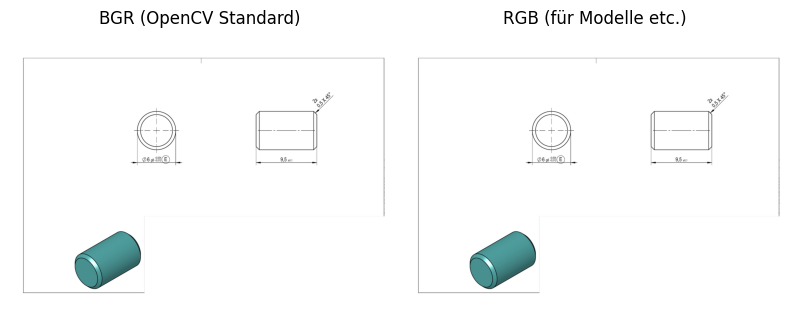

In [49]:
test_image_color_conversion("../data/rotation//batches/rotation_20250708_01/images/default/10000.png")


## 2 · COCO helpers & utils

In [36]:
def load_coco(json_path: Path) -> Dict[str, Any]:
    with open(json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)
    return coco

    

def create_obb_tuple(anns):
    bbox = anns.get("bbox", "No bbox found")
    if(len(bbox) == 4):    
        x, y, w, h = anns["bbox"]
        cx = x + (w/2)
        cy = y + (h/2)
        angle = anns["attributes"].get("rotation", 0.0)
        obb_list = [cx, cy, w, h, angle]
        anns["bbox"] = obb_list
    else: 
        #print(f"type = {type(bbox)}, length = {len(bbox) if hasattr(bbox, '__len__') else 'N/A'}, bbox: {bbox}")
        print("Weirdle after every element is on 5 tuples it starts to iterate again")



def replace_obb(coco, batchdir):
    for anns in coco['annotations']:
        create_obb_tuple(anns)
        
    json_object = json.dumps(coco)
    with open(batchdir / "annotations" / "instances_updated.json", mode="w") as file:
        file.write(json_object)
              
        
def convert_all_batches():
    for p in BATCHES_DIR.iterdir():
        if "rotation" in p.name:
            print(p.name)
            json_path = p / "annotations" / "instances_default.json"
            print(json_path)
            #coco = load_coco(json_path)
            replace_obb(load_coco(json_path), p)
            
        
        
convert_all_batches()        

rotation_20250708_01
../data/rotation/batches/rotation_20250708_01/annotations/instances_default.json
rotation_20250708_02
../data/rotation/batches/rotation_20250708_02/annotations/instances_default.json


## Debug

In [37]:
def lookAtCoco(json_path: Path):
    coco = load_coco(json_path)
    print(f"Coco {coco}")
    print(f"Keys {coco.keys()}")
    print(f"Values {coco.values()}")
    print(f"Items {coco.items()}")

    print(f"Images      : {(coco['images'])}")
    print(f"Annotations : {(coco['annotations'])}")
    print(f"Categories  : {(coco['categories'])}\n")
    
    
def debug_bbox(coco):
    for i, anns in enumerate(coco['annotations']):
        bbox = anns.get("bbox", "No bbox found")
        print(f"Annotation {i}: bbox = {bbox}, type = {type(bbox)}, length = {len(bbox) if hasattr(bbox, '__len__') else 'N/A'}")

In [17]:
def crop_oriented_bbox(img, cx, cy, w, h, theta):
    # Step 1: Rotate the entire image around the bbox center
    M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    # Step 2: Crop the now-aligned rectangle
    x1 = int(cx - w/2)
    y1 = int(cy - h/2)
    x2 = int(cx + w/2)
    y2 = int(cy + h/2)
    
    # Ensure bounds are within image
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
    
    cropped = rotated[y1:y2, x1:x2]
    return cropped

In [29]:
def crop_all_boxes():
    for p in BATCHES_DIR.iterdir():
        if "rotation" in p.name and (p/ "annotations" / "instances_updated.json").exists() and (p/ "images").exists():
            print(p)
            
            image_path = p/ "images" / "default"  
            print((image_path))
            
            coco = load_coco(p/ "annotations" / "instances_updated.json")
            
            print(coco.keys())
            count = 1
            
            DEST_IMG_DIR = Path(f'../data/rotation/batches/{p.name}/images/boxes')
            DEST_IMG_DIR.mkdir(parents=True, exist_ok=True)

            for anns in coco["annotations"]:
                if count <= 50: 
                    cx, cy, w, h, theta = anns["bbox"]
                    image_id = anns["image_id"]

                    print(anns["image_id"])
                    img_meta = next((img for img in coco["images"] if img["id"] == image_id), None)
                    print(img_meta)
                    print(type(img_meta))
                    file_name = img_meta.get('file_name')
                    print(file_name)
                    
                    file_number = file_name.replace('.png', "")
                    print(file_number)
                    
                    img_arr = cv2.imread(image_path / file_name)
                    
                    print(image_path)
                    
                    
                    rotated_box = crop_oriented_bbox(img_arr, cx, cy, w, h, theta)
                    
                    cv2.imwrite(f'{p}/images/boxes/{file_number}_{anns["id"]}.png', rotated_box)


                    count = count + 1
                else:
                    break 
                
            
crop_all_boxes()

../data/rotation/batches/rotation_20250708_01
../data/rotation/batches/rotation_20250708_01/images/default
dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])
1
{'id': 1, 'width': 3055, 'height': 2160, 'file_name': '10000.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
<class 'dict'>
10000.png
10000
../data/rotation/batches/rotation_20250708_01/images/default
1
{'id': 1, 'width': 3055, 'height': 2160, 'file_name': '10000.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
<class 'dict'>
10000.png
10000
../data/rotation/batches/rotation_20250708_01/images/default
1
{'id': 1, 'width': 3055, 'height': 2160, 'file_name': '10000.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
<class 'dict'>
10000.png
10000
../data/rotation/batches/rotation_20250708_01/images/default
1
{'id': 1, 'width': 3055, 'height': 2160, 'file_name': '10000.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0

In [ ]:
# Looking at Image

if not os.path.exists(image_file):
    print(f"Error: The image file {image_file} does not exist.")
else:
    print("Image file exists. Attempting to read the image...")
    image_1 = cv2.imread(image_file)
    if image_1 is None:
        print("Error: Could not read the image.")
    else:
        print("Image read successfully. Attempting to display the image...")
        cv2.imshow("test", image_1)
        print("Image displayed. Press any key to close the window...")

        while True:
            key = cv2.waitKey(1) & 0xFF
            if key != 255:
                print(f"Key pressed: {key}. Closing the window...")
                break

        cv2.destroyAllWindows()
        print("Window closed.")


Image file exists. Attempting to read the image...
Image read successfully. Attempting to display the image...
Image displayed. Press any key to close the window...


2025-07-08 14:07:58.162 python[69462:8755635] +[IMKClient subclass]: chose IMKClient_Legacy
2025-07-08 14:07:58.162 python[69462:8755635] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


Key pressed: 102. Closing the window...
Window closed.


In [43]:
import cv2
import numpy as np

def rotate_patch(patch, angle):
    h, w = patch.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    cos, sin = abs(M[0,0]), abs(M[0,1])
    new_w, new_h = int(h*sin + w*cos), int(h*cos + w*sin)
    M[0,2] += new_w/2 - w/2
    M[1,2] += new_h/2 - h/2

    # Prüfen ob Bild einen Alphakanal hat
    if patch.shape[2] == 4:
        # Transparenz beibehalten
        rotated = cv2.warpAffine(
            patch,
            M,
            (new_w, new_h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0, 0)  # Transparenter Hintergrund
        )
        print("Image has alpha channel")
    else:
        # Kein Alphakanal → normal mit weißem Hintergrund
        rotated = cv2.warpAffine(
            patch,
            M,
            (new_w, new_h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(255, 255, 255)
        )
        print("No alpha channel")

    return rotated


In [44]:
img_arr = cv2.imread("../data/rotation/batches/rotation_20250708_01/images/boxes/10000_1.png")


rotated_box = rotate_patch(img_arr, 90)
                    
cv2.imwrite('test.png', rotated_box)

No alpha channel


True

In [32]:
ANGLES: List[int]   = [0, 45, 90, 180, 270, 360]


In [33]:
def process_dataset(src_img_dir: Path, coco_json: Path, dest_img_dir: Path,
                    angles: List[int] = ANGLES, every: int = 200):
    
    
    coco = load_coco(coco_json)
    


## 7 · Interactive inspect()

## 8 · Smoke test

## 9 · Run full dataset

intersting features to add>


Extra diagnostics to explain **where cropping goes wrong** and to display key COCO fields for every patch:
* verbose per‑annotation banner with image/annotation IDs & bbox details
* lost‑pixels report when a crop gets clipped by image borders
* `inspect()` prints the category, bbox, rotation and lost‑pixel stats
* helper `overlay_bbox()` overlays the rotated‑back bbox for visual sanity checks